In [1]:
import jax.numpy as jnp
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
import netket as nk
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
from scipy.sparse.linalg import eigsh
from grad_sample.models.system.system import Square_Heisenberg
from grad_sample.models.heisenberg import XXZ
from grad_sample.utils.plotting_setup import *

In [2]:
H_heisenberg = Square_Heisenberg(J = [1.0],
L=4,
sign_rule=[0.0]).hamiltonian.to_sparse()

H_j1j2 = lambda j2 : Square_Heisenberg(J = [1.0, j2],
L=4,
sign_rule=[0.0, 0.0]).hamiltonian.to_sparse()

In [3]:
import pubchempy as pcp
from pyscf import gto, scf, fci, cc, mcscf

# 1. Load the N2 molecule from PubChem (3D structure)
cid = 947  # N2 molecule
compound = pcp.get_compounds(cid, "cid", record_type="3d")[0]

# 2. Extract atomic coordinates
geometry = []
for atom in compound.atoms:
    symbol = atom.element
    x, y, z = atom.x, atom.y, atom.z
    geometry.append(f"{symbol} {x} {y} {z}")

# Convert to PySCF format
mol_geometry = "\n".join(geometry)

# 3. Define the molecule in PySCF
mol = gto.Mole()
mol.atom = mol_geometry
mol.basis = "STO-3G"  # Choose a reasonable basis set
mol.unit = "angstrom"  # Coordinates are in Ångströms
mol.spin = 0  # N2 is a singlet
mol.charge = 0
mol.build()

# 4. Run Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()

# 5. Compute Full Configuration Interaction (FCI) energy
cisolver = fci.FCI(mol, mf.mo_coeff)
E0 = cisolver.kernel()[0]

# Print results
print(f"Hartree-Fock Energy: {mf.e_tot:.6f} Ha")
print(f"FCI Ground State Energy: {E0:.6f} Ha")

converged SCF energy = -107.498967544584
Hartree-Fock Energy: -107.498968 Ha
FCI Ground State Energy: -107.660206 Ha


In [4]:
import netket.experimental as nkx
from netket_pro.operator import ParticleNumberConservingFermioperator2ndSpinJax
mf = scf.RHF(mol).run()  
ccsd = cc.ccsd.CCSD(mf).run()
nat_orbs = mcscf.addons.make_natural_orbitals(ccsd)
# use the boys orbitals to construct the netket hamiltonian
# natorbital hamiltonian
ha_pyscf = nkx.operator.from_pyscf_molecule(mol, mo_coeff=nat_orbs[1]).to_jax_operator()
ha_natorb = ParticleNumberConservingFermioperator2ndSpinJax.from_fermiop(ha_pyscf)
# E0, gs = nk.exact.lanczos_ed(ha_def, compute_eigenvectors=True)

converged SCF energy = -107.498967544584
E(CCSD) = -107.6560799973304  E_corr = -0.1571124527464685


In [5]:
# from functools import lru_cache
# from functools import cache
# ha_pyscf = nkx.operator.from_pyscf_molecule(mol, mo_coeff=nat_orbs[1]).to_jax_operator()
# ha_natorb = ParticleNumberConservingFermioperator2ndSpinJax.from_fermiop(ha_pyscf)

# @lru_cache(5)
# def sparsify(Ô):
#     """
#     Converts to sparse but also cache the sparsificated result to speed up.
#     """
#     return Ô.to_sparse()

# sparsify(ha_natorb)


In [6]:
def ipr(gs):
    return jnp.sum(gs**4)

In [7]:
from flax import nnx
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from typing import Any, Callable, Sequence
from functools import partial
import jax
DType = Any

class LogNeuralJastrowSlater(nnx.Module):
    hilbert: nk.hilbert.SpinOrbitalFermions

    def __init__(self, hilbert, jastrow_hidden_units: int=64, kernel_init=default_kernel_init, param_dtype=float, *, rngs: nnx.Rngs):
        self.hilbert = hilbert
        # To generate random numbers we need to extract the key from the `rngs` object.
        key = rngs.params()

        # the N x Nf matrix of the orbitals
        self.M = nnx.Param(kernel_init(key, (2*self.hilbert.n_orbitals, self.hilbert.n_fermions,), param_dtype))

        # The Neural Jastrow wf
        self.jastrow_linear = nnx.Linear(in_features=2*self.hilbert.n_orbitals, out_features=jastrow_hidden_units, param_dtype=param_dtype, rngs=rngs)
        # self.jastrow_hidden = nnx.Linear(in_features=jastrow_hidden_units, out_features=jastrow_hidden_units, param_dtype=param_dtype, rngs=rngs)
        
    def __call__(self, n: jax.Array) -> jax.Array:
        # For simplicity, we write a function that operates on a single configuration of size (N,)
        # and we vectorize it using `jnp.vectorize` with the signature='(n)->()' argument, which specifies
        # that the function is defined to operate on arrays of shape (n,) and return scalars.
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Construct the Neural Jastrow
            J = self.jastrow_linear(n)
            J = jax.nn.tanh(J)
            # J = self.jastrow_hidden(J)
            # J = jax.nn.relu(J)
            J = J.sum()

            # Construct the slater determinant 
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            # Extract from the (N, Nf) matrix the (Nf, Nf) submatrix of M corresponding to the occupied orbitals.
            A = self.M[R]
            log_slater = nk.jax.logdet_cmplx(A)

            # Multiply log slater with the jastrow (and since we are working in log space, this becomes a sum)
            return log_slater + J

        return log_sd(n)

In [8]:
class LogNeuralBackflow(nnx.Module):
    hilbert: nk.hilbert.SpinOrbitalFermions

    def __init__(self, hilbert, hidden_units: int, kernel_init=default_kernel_init, param_dtype=float, *, rngs: nnx.Rngs):
        self.hilbert = hilbert

        # To generate random numbers we need to extract the key from the `rngs` object.
        key = rngs.params()

        # the N x Nf matrix of the orbitals
        self.M = nnx.Param(kernel_init(key, (2*self.hilbert.n_orbitals, self.hilbert.n_fermions,), param_dtype))

        # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
        # that modifies the bare orbitals.
        self.backflow = nnx.Sequential(
            # First layer, input (..., N,) output (..., hidden_units)
            nnx.Linear(in_features=hilbert.size, out_features=hidden_units, param_dtype=param_dtype, rngs=rngs),
            nnx.tanh,
            # Two hidden layers like original paper
            # nnx.Linear(in_features=hidden_units, out_features=hidden_units, param_dtype=param_dtype, rngs=rngs),
            # nnx.relu,
            # nnx.Linear(in_features=hidden_units, out_features=hidden_units, param_dtype=param_dtype, rngs=rngs),
            # nnx.relu,

            # Last layer, input (..., hidden_units,) output (..., N x Nf)
            nnx.Linear(in_features=hidden_units, out_features=2*hilbert.n_orbitals*hilbert.n_fermions, param_dtype=param_dtype, rngs=rngs),
            # Reshape into the orbital shape, (..., N, Nf)
            lambda x: x.reshape(x.shape[:-1] + (2 * hilbert.n_orbitals, hilbert.n_fermions))
        )

    def __call__(self, n: jax.Array) -> jax.Array:
        # For simplicity, we write a function that operates on a single configuration of size (N,)
        # and we vectorize it using `jnp.vectorize` with the signature='(n)->()' argument, which specifies
        # that the function is defined to operate on arrays of shape (n,) and return scalars.
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
            # that modifies the bare orbitals.
            F = self.backflow(n)
            # Add the backflow correction to the bare orbitals
            M = self.M + F
            
            # Find the positions of the occupied, backflow-modified orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            A = M[R]
            return nk.jax.logdet_cmplx(A)

        return log_sd(n)

In [9]:
import flax.linen as nn
import netket as nk
import jax.numpy as jnp
from netket.nn.masked_linear import default_kernel_init
from typing import Any
import jax

DType = Any

class LogNeuralBackflow(nn.Module):
    hilbert: nk.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: Any = default_kernel_init
    param_dtype: Any = jnp.float32

    def setup(self):
        """Initialize model parameters."""
        # The N x Nf matrix of the orbitals
        self.M = self.param(
            "M", self.kernel_init, 
            (2 * self.hilbert.n_orbitals, self.hilbert.n_fermions), 
            self.param_dtype
        )

        # Construct the Backflow: Takes (N,) occupation numbers -> (N, Nf) orbital transformation matrix
        self.backflow = nn.Sequential([
            nn.Dense(features=self.hidden_units, param_dtype=self.param_dtype),
            nn.tanh,
            nn.Dense(features=2 * self.hilbert.n_orbitals * self.hilbert.n_fermions, param_dtype=self.param_dtype),
            lambda x: x.reshape(x.shape[:-1] + (2 * self.hilbert.n_orbitals, self.hilbert.n_fermions))
        ])

    def log_sd(self, n: jax.Array) -> jax.Array:
        """Compute the log of the Slater determinant with backflow for a single input sample."""
        # Compute backflow correction
        F = self.backflow(n)
        M = self.M + F

        # Find occupied orbitals
        R = n.nonzero(size=self.hilbert.n_fermions)[0]
        A = M[R]
        return nk.jax.logdet_cmplx(A)

    def __call__(self, n: jax.Array) -> jax.Array:
        """Vectorized computation over batches."""
        return jax.vmap(self.log_sd)(n)

In [10]:
# Number of spatial orbitals
N_orbitals = ha_natorb.hilbert.n_orbitals # Assume hilbert.size counts spin-orbitals

# Total number of nodes (each orbital has two spin states)
N_sites = N_orbitals  

edges = []

# Add horizontal edges (ladder rungs connecting spin-up and spin-down of same orbital)
for i in range(N_orbitals):
    edges.append((i, i + N_orbitals))  # Connect spin-up (i) to spin-down (i + N_orbitals)

# Add vertical edges (along spin-up and spin-down chains separately)
for i in range(N_orbitals - 1):
    edges.append((i, i + 1))  # Spin-up chain
    edges.append((i + N_orbitals, i + 1 + N_orbitals))  # Spin-down chain

# Create a ladder graph
graph = nk.graph.Graph(edges=edges)
g = nk.graph.Chain(ha_natorb.hilbert.n_orbitals, pbc=False)
exchange_graph = nk.graph.disjoint_union(g, g)

In [11]:
ha_natorb.hilbert.n_states

14400

In [12]:
from netket.vqs import FullSumState
import copy
import netket.jax as nkjax
def compute_snr_callback(step, logdata, driver, fs_state:FullSumState):
    # estimate local grad
    if step % 10 == 0:
        # fs_state = FullSumState(hilbert = driver.state.hilbert, model = driver.state.model, chunk_size=None, seed=0)
        fs_state.variables = copy.deepcopy(driver.state.variables)
        pdf = fs_state.probability_distribution()
        vstate_arr = fs_state.to_array()
        H_sp = driver._ham.to_sparse()
        Hloc = H_sp @ vstate_arr / vstate_arr
        Hloc_c = (Hloc - jnp.sum(Hloc*pdf))
        mode = "complex"
        # uncentered jacobian
        jacobian_orig = nkjax.jacobian(
            fs_state._apply_fun,
            fs_state.parameters,
            fs_state.hilbert.all_states(), #in MC state, this is vstate.samples
            fs_state.model_state,
            pdf=pdf,
            mode=mode,
            dense=True,
            center=False,
            chunk_size=10,
            _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
        )

        # (#ns, 2) -> (#ns*2)
        Hloc_2 = jnp.stack([jnp.real(Hloc_c), jnp.imag(Hloc_c)], axis=-1)
        Hloc_c = jax.lax.collapse(Hloc_2, 0, 2)
        jacobian_orig_c = jacobian_orig - jnp.sum(jacobian_orig*jnp.expand_dims(pdf, range(len(jacobian_orig.shape))[1:]),axis=0)
        jacobian_orig_c = jax.lax.collapse(jacobian_orig_c, 0, 2)
        loc_grad_v = jacobian_orig_c.T * Hloc_c
        loc_grad_v = loc_grad_v[:, ::2] + loc_grad_v[:, 1::2]
        
        # print(loc_grad_v.shape)
        # n_p = loc_grad_v.shape[0]//2
        # print(loc_grad_v_holo - (loc_grad_v[:n_p,:] + 1j* loc_grad_v[n_p:,:]))


        mean_grad_unc = jnp.sum(jnp.abs(pdf * loc_grad_v), axis=0) / jnp.sum(jnp.abs(pdf * loc_grad_v))
        
        def unnorm_pdf(alpha):
            return (jnp.abs(vstate_arr)**alpha)
        
        def compute_snr(q):
            q_pdf = q / jnp.sum(q)
            w_mean = jnp.sum(q_pdf * unnorm_pdf(2.0)/q)**2
            v = jnp.sum(q_pdf * (unnorm_pdf(2.0)/q)**2 * jnp.abs(loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=1)[:, None])**2, axis=1)/w_mean
            return jnp.mean(jnp.abs(jnp.sum(pdf * loc_grad_v, axis = 1)) / jnp.sqrt(v))
        
        a_vals = jnp.linspace(0,2,50)
        snr_a = jnp.array([compute_snr(unnorm_pdf(a)) for a in a_vals])
        argmax_index = jnp.argmax(snr_a)
        argmax_a = a_vals[argmax_index]
        # print(jnp.mean(unnorm_pdf(2.0) * jnp.abs(loc_grad_v), axis=0).shape)
        snr_grad = compute_snr(jnp.mean(unnorm_pdf(2.0) * jnp.abs(loc_grad_v), axis=0))
        
        logdata['snr_a'] = snr_a
        logdata['snr_grad'] = snr_grad
        logdata['max_snr_a'] = max(snr_a)
        logdata['argmax_snr_a'] = argmax_a
        logdata['snr_psi_sq'] = compute_snr(unnorm_pdf(2.0))
        # logdata['snr_hpsi'] = compute_snr(jnp.abs(driver._ham @ vstate_arr))
        logdata['grad_mag'] = jnp.mean(jnp.abs(loc_grad_v), axis=0)
    return True
        

In [ ]:
# Create a Neural Jastrow Slater wave function 
import auto_importance as advd
import optax
from grad_sample.utils.utils import save_rel_err_fs
from functools import partial
model = LogNeuralBackflow(ha_natorb.hilbert, hidden_units=16)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisFermionHop(ha_natorb.hilbert, graph=exchange_graph)
lr_schedule = optax.cosine_decay_schedule(
                                        init_value=0.1,
                                        decay_steps=300,
                                        alpha=0.1
                                        )
opt = nk.optimizer.Sgd(learning_rate=0.022 )
# Create a variational state
sa_exact = nk.sampler.ExactSampler(ha_natorb.hilbert)
vstate = nk.vqs.MCState(sa_exact, model, n_samples=2**9, chunk_size=2**12)
is_distrib = advd.driver.overdispersed_distribution(0.75)

gs = advd.driver.VMC_NG(ha_natorb.to_jax_operator(),
            opt,
            sampling_distribution=is_distrib,
            variational_state=vstate,
            diag_shift=1e-4,
            auto_is=False,
            use_ntk=True,
            on_the_fly=False)

diag_shift_sch = optax.linear_schedule(
                                    init_value=1e-4,
                                    transition_steps=400,
                                    end_value=1e-6
                                    )

sr = nk.optimizer.SR(qgt=nk.optimizer.qgt.QGTJacobianDense, 
                            solver=nk.optimizer.solver.cholesky, 
                            diag_shift=diag_shift_sch, 
                            holomorphic = False,
                            )

vstate_fs = nk.vqs.FullSumState(hilbert = ha_natorb.hilbert, model=model, chunk_size=600)

save_rel_err_cb = partial(save_rel_err_fs, 
                                           e_gs = E0, 
                                           fs_state = vstate_fs, 
                                           save_every=10, 
                            )
snr_cb = partial(compute_snr_callback, fs_state=vstate_fs)

gs_fs = nk.driver.VMC(ha_pyscf.to_jax_operator(),
                      opt,
                      variational_state=vstate_fs,
                      preconditioner=sr)
# Construct the logger to visualize the data later on
nj_log_adapt=nk.logging.RuntimeLog()

# Run the optimization for 500 iterations
# gs_fs.run(n_iter=300, out=nj_log_adapt, 
#           callback = (snr_cb,)
#           )
# gs.run(n_iter=500, out=nj_log_adapt, 
#     #    callback = (snr_cb, save_rel_err_cb)
#        )

/scratch/.amisery/netket2/lib/python3.11/site-packages/netket/vqs/full_summ/state.py:261: UserWarning: For performance reasons, we suggest to use a power-of-two chunk size.
  warnings.warn(


In [14]:
gs.run(n_iter=500, out=nj_log_adapt, 
    #    callback = (snr_cb, save_rel_err_cb)
       )

100%|██████████| 500/500 [03:34<00:00,  2.33it/s, Energy=-107.7-0.0j ± 11.2 [σ²=88942.9]] 


(RuntimeLog():
  keys = ['Energy'],)

-107.65912637817843


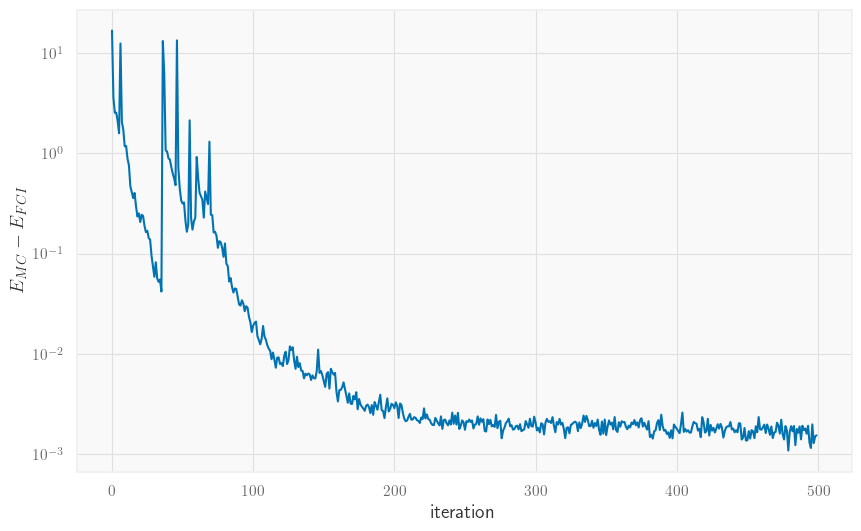

In [15]:
# plt.plot(out['rel_err']['value'])
print(min(nj_log_adapt['Energy']['Mean'].real))
plt.plot(nj_log_adapt['Energy']['Mean'].real - E0)
plt.ylabel(r'$E_{MC} - E_{FCI}$')
plt.xlabel(r'iteration')
plt.yscale('log')

KeyError: 'argmax_snr_a'

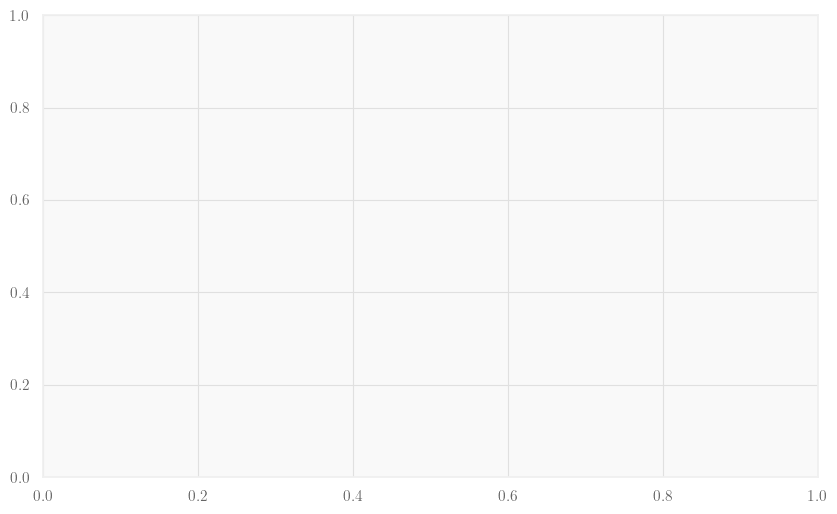

In [16]:
fig, ax = plt.subplots()
out = nj_log_adapt
rel_err_vals = jnp.array(jnp.abs(nj_log_adapt['Energy']['Mean'].real -E0)/jnp.abs(E0))[nj_log_adapt['argmax_snr_a']['iters']]
rel_err_vals = out['rel_err']['value']
idx_sort = jnp.flip(jnp.argsort(rel_err_vals))

rel_err_vals_s = rel_err_vals[idx_sort]
# ax.plot(rel_err_vals_s, jnp.array(out['snr_grad']['value'])[idx_sort], label=r'gradient SNR with $\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|$')
ax.plot(rel_err_vals_s, jnp.array(out['max_snr_a']['value'])[idx_sort], label='SNR with best overdispersed coeff.')
ax.plot(rel_err_vals_s, jnp.array(out['snr_psi_sq']['value'])[idx_sort], label=r'SNR, $|\psi|^2$')
# ax.plot(rel_err_vals_s, jnp.array(out['snr_hpsi']['value'])[idx_sort], label=r'SNR, $|\bra{x}H\ket{\psi}|$')
# ax.plot(rel_err_vals_s, jnp.array(out['info']['snr']['value'])[good_vals][idx_sort], label='SNR with best overdispersed coeff.')
ax1 = ax.twinx()

ax1.plot(rel_err_vals_s, jnp.array(out['argmax_snr_a']['value'])[idx_sort], color='black', label=r"optimal $\alpha$ throughout training")
# ax1.plot(rel_err_vals_s, jnp.array(out['alpha']['value'])[good_vals][idx_sort], color='red', label=r'automatically tuned $\alpha$')
ax1.set_xscale('log')
ax.set_xlabel("Relative error to exact ground state")
ax.set_ylabel('SNR')
ax1.set_ylabel(r"$\alpha$")
ax.set_yscale('log')
ax.set_xscale('log')
# Retrieve and combine legends
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
ax.legend(handles_ax + handles_ax1, labels_ax + labels_ax1, bbox_to_anchor=(1.1, 1))
# plt.legend()
plt.title(r"SNR and optimal overdispersion coefficient over training on the $N_2$ molecule, NNBF")

In [27]:
nj_log_adapt.data

HistoryDict with 8 elements:
	'Energy' -> History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=500)
	'argmax_snr_a' -> History(keys=['value'], n_iters=50)
	'grad_mag' -> History(keys=['value'], n_iters=50)
	'max_snr_a' -> History(keys=['value'], n_iters=50)
	'rel_err' -> History(keys=['value'], n_iters=50)
	'snr_a' -> History(keys=['value'], n_iters=50)
	'snr_grad' -> History(keys=['value'], n_iters=50)
	'snr_psi_sq' -> History(keys=['value'], n_iters=50)

In [28]:
import json
# Convert HistoryDict to a serializable format
def convert_to_serializable(obj):
    """Recursively converts HistoryDict or numpy objects into JSON serializable formats."""
    if isinstance(obj, nk.utils.HistoryDict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif hasattr(obj, "tolist"):  # Convert numpy arrays to lists
        return obj.tolist()
    else:
        return obj  # Assume it's already serializable

# Convert and save to JSON
with open("runtime_log.json", "w") as f:
    json.dump(convert_to_serializable(nj_log_adapt.data), f, indent=4)

AttributeError: module 'netket.utils' has no attribute 'HistoryDict'

In [1]:
jnp.savez("log_nnbf_snr.npz", nj_log_adapt.data)

NameError: name 'jnp' is not defined

In [44]:
jnp.load("log_nnbf_snr.npz", allow_pickle=True)['arr_0']

array(['Energy', 'snr_a', 'snr_grad', 'max_snr_a', 'argmax_snr_a',
       'snr_psi_sq', 'grad_mag', 'rel_err'], dtype='<U12')

TypeError: 'VMC_NG' object is not subscriptable

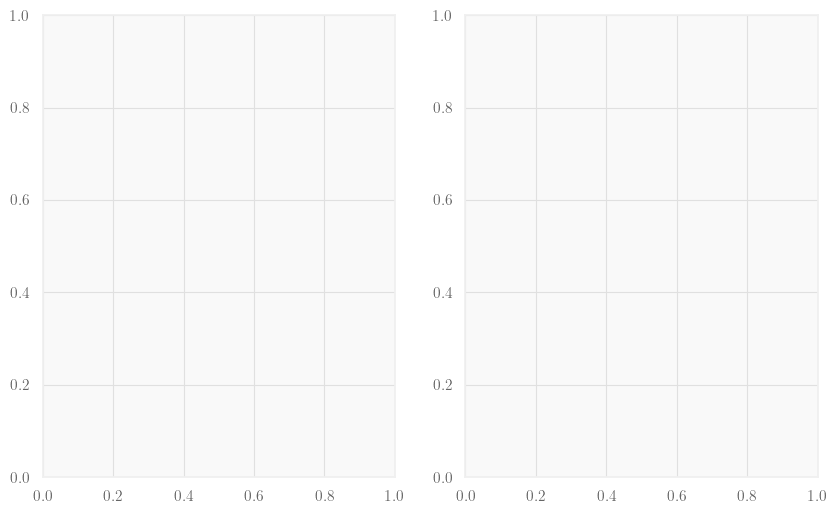

: 

: 

: 

: 

In [23]:
fig, axes = plt.subplots(1,2)
sorted_gs = sorted(jnp.abs(gs[:,0]))[::-1]
sorted_gs = jnp.array(sorted_gs)
ipr(sorted_gs)
axes[0].plot(sorted_gs)
sorted_gs_nat = sorted(jnp.abs(gsnat[:,0]))[::-1]
sorted_gs = jnp.array(sorted_gs)
ipr(sorted_gs)
axes[1].plot(sorted_gs_nat)
plt.yscale('log')

In [ ]:
# from matplotlib.cm import viridis, seismic, coolwarm, Spectral

# colors = viridis(jnp.linspace(0, 1,10))
# for idx, alpha in enumerate(jnp.linspace(0.1,1,10)):
#     plt.plot(sorted_gs**alpha/jnp.sum(sorted_gs**alpha), label=r"$\alpha=%.2f$"%alpha, color=colors[idx])
# plt.legend()
# plt.plot(sorted_gs**2)
# plt.yscale('log')
# plt.ylim(bottom=1e-10)
# plt.yscale('log')
# plt.ylim(bottom=1e-10)

: 

: 

: 

: 

: 

: 

In [3]:
H_xxz_l = [XXZ(L=16, J=h).hamiltonian.to_sparse() for h in [4,5,6,7,8]]
H_xxz = XXZ(L=16)

: 

: 

: 

: 

In [4]:
def get_gs(H_sp):
    eig_vals, eig_vecs = eigsh(
            H_sp, k=2, which="SA"
        )  # k is the number of eigenvalues desired,
    E_gs = eig_vals[0]  # "SA" selects the ones with smallest absolute value
    gs = eig_vecs[:,0]
    return jnp.sort(jnp.abs(jnp.array(gs)))

: 

: 

: 

: 

In [12]:
heisenberg_gs = get_gs(H_heisenberg)

: 

: 

: 

: 

: 

: 

In [13]:
gs_j1j2 = get_gs(H_j1j2(0.5))

: 

: 

: 

: 

: 

: 

In [14]:
gs_j1j2_1 = get_gs(H_j1j2(1.0))

: 

: 

: 

: 

: 

: 

In [15]:
gs_xxz = get_gs(H_xxz)

: 

: 

: 

: 

: 

: 

In [5]:
gs_xxz_l = [get_gs(H) for H in H_xxz_l]

: 

: 

: 

: 

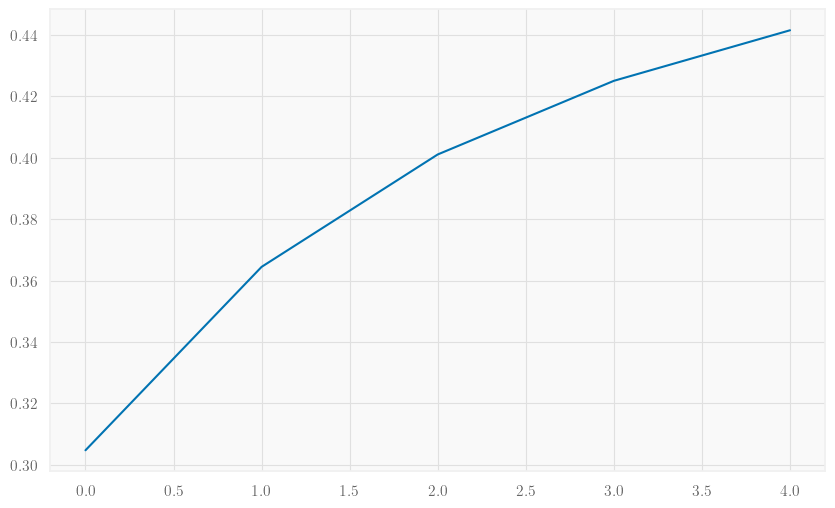

: 

: 

: 

: 

In [6]:
plt.plot([jnp.sum(gs**4) for gs in gs_xxz_l])

(1e-10, np.float64(35.98191461101676))

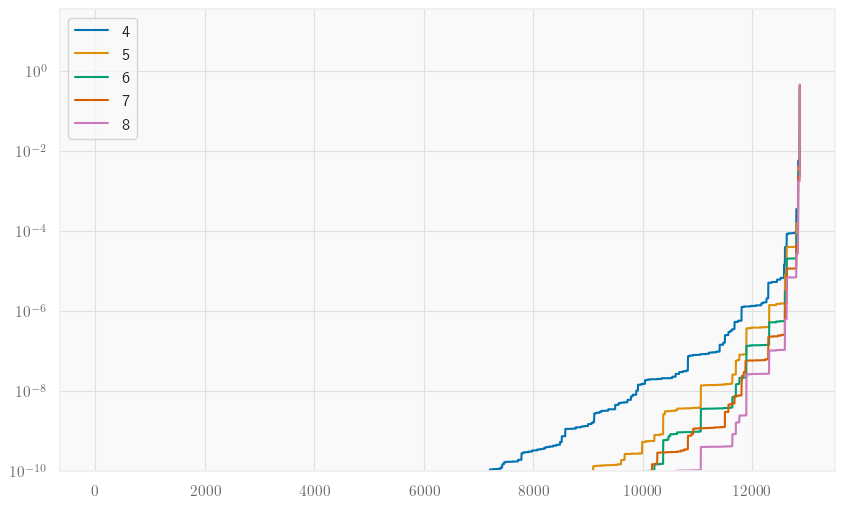

: 

: 

: 

: 

In [8]:
plt.plot(jnp.array(gs_xxz_l).T**2, label = [4,5,6,7,8])
plt.yscale('log')
plt.legend()
plt.ylim(bottom=1e-10)

In [19]:
print(ipr(gs_xxz))
print(ipr(gs_j1j2))
print(ipr(gs_j1j2_1))
print(ipr(heisenberg_gs))

0.020238550527017514
0.0030399735148109105
0.007497759747610655
0.014529147808521615


: 

: 

: 

: 

: 

: 

(1e-11, np.float64(0.7518266873768118))

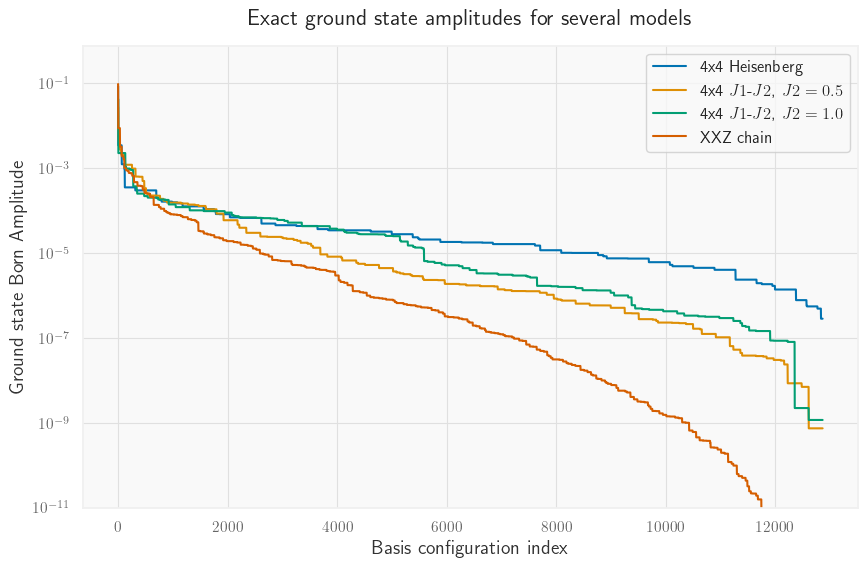

: 

: 

: 

: 

: 

: 

In [27]:
plt.plot(heisenberg_gs[::-1]**2, label= r"4x4 Heisenberg")
plt.plot(gs_j1j2[::-1]**2, label = r"4x4 $J1$-$J2$, $J2=0.5$")
plt.plot(gs_j1j2_1[::-1]**2, label = r"4x4 $J1$-$J2$, $J2=1.0$")
plt.plot(gs_xxz[::-1]**2, label= 'XXZ chain')
plt.legend()
plt.title('Exact ground state amplitudes for several models')
plt.xlabel('Basis configuration index')
plt.ylabel("Ground state Born Amplitude")
plt.yscale('log')
plt.ylim(bottom=1e-11)

(1e-11, np.float64(0.17136710302684224))

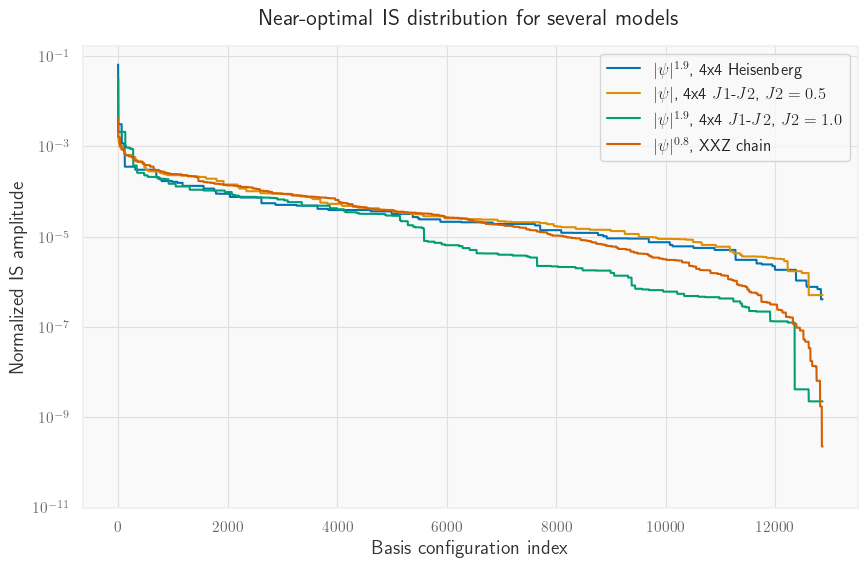

: 

: 

: 

: 

: 

: 

In [55]:
plt.plot(jnp.array(heisenberg_gs[::-1])**1.9/jnp.sum(jnp.array(heisenberg_gs[::-1])**1.9), label= r"$|\psi|^{1.9}$, 4x4 Heisenberg")
plt.plot(jnp.array(gs_j1j2[::-1])/jnp.sum(jnp.array(gs_j1j2[::-1])), label = r"$|\psi|$, 4x4 $J_1$-$J_2$, $J_2=0.5$")
plt.plot(jnp.array(gs_j1j2_1[::-1])**1.9/jnp.sum(jnp.array(gs_j1j2_1[::-1])**1.9), label = r"$|\psi|^{1.9}$, 4x4 $J_1$-$J_2$, $J_2=1.0$")
plt.plot(jnp.array(gs_xxz[::-1])**0.8/jnp.sum(jnp.array(gs_xxz[::-1])**0.8), label= r'$|\psi|^{0.8}$, XXZ chain')
plt.legend()
plt.title('Near-optimal IS distribution for several models')
plt.xlabel('Basis configuration index')
plt.ylabel("Normalized IS amplitude")
plt.yscale('log')
plt.ylim(bottom=1e-11)